In [55]:
import numpy as np
import pandas as pd 
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

In [56]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda:0


In [57]:
train_data = pd.read_csv("./abalone_train.data", names=['label','Length','Diameter','Height','WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWight', 'Rings'])
test_data = pd.read_csv("./abalone_test.data", names=['label','Length','Diameter','Height','WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWight', 'Rings'])

# `sort = True` to make sure the consistance of train/test data
train_data['label'], unique_seq = pd.factorize(train_data.label, sort=True)
test_data['label'] = pd.factorize(test_data.label, sort=True)[0]

classes_num = unique_seq.shape[0]
print(train_data)
print(test_data)
print(classes_num)

      label  Length  Diameter  Height  WholeWeight  ShuckedWeight  \
0         2   0.455     0.365   0.095       0.5140         0.2245   
1         2   0.350     0.265   0.090       0.2255         0.0995   
2         0   0.530     0.420   0.135       0.6770         0.2565   
3         2   0.440     0.365   0.125       0.5160         0.2155   
4         1   0.330     0.255   0.080       0.2050         0.0895   
...     ...     ...       ...     ...          ...            ...   
3448      0   0.565     0.450   0.165       0.8870         0.3700   
3449      2   0.590     0.440   0.135       0.9660         0.4390   
3450      2   0.600     0.475   0.205       1.1760         0.5255   
3451      0   0.625     0.485   0.150       1.0945         0.5310   
3452      2   0.710     0.555   0.195       1.9485         0.9455   

      VisceraWeight  ShellWight  Rings  
0            0.1010      0.1500     15  
1            0.0485      0.0700      7  
2            0.1415      0.2100      9  
3      

In [58]:
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)

train_x = train_data[:,1:]
print(train_x)
train_y = train_data[:,0]

test_x = test_data[:,1:]
# print(test_x)
test_y = test_data[:,0]

print(train_y[:10])
print(test_y[:10])

train_x = torch.tensor(train_x, dtype=torch.float).to(device) 
train_y = torch.tensor(train_y, dtype=torch.long).to(device)
test_x = torch.tensor(test_x, dtype=torch.float).to(device)
test_y = torch.tensor(test_y, dtype=torch.long).to(device)

[[ 0.455   0.365   0.095  ...  0.101   0.15   15.    ]
 [ 0.35    0.265   0.09   ...  0.0485  0.07    7.    ]
 [ 0.53    0.42    0.135  ...  0.1415  0.21    9.    ]
 ...
 [ 0.6     0.475   0.205  ...  0.2875  0.308   9.    ]
 [ 0.625   0.485   0.15   ...  0.261   0.296  10.    ]
 [ 0.71    0.555   0.195  ...  0.3765  0.495  12.    ]]
[2. 2. 0. 2. 1. 1. 0. 0. 2. 0.]
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]


In [59]:
batch_size = 512

train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_ds = TensorDataset(test_x, test_y)
test_dl = DataLoader(test_ds, batch_size=batch_size)

input_features = train_x.shape[1]
output_features = classes_num

In [60]:
class NeuroNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_features,32),
            nn.ReLU(),
            # nn.Linear(32,128),
            # nn.ReLU(),
            # nn.Linear(128,32),
            # nn.ReLU(),
            nn.Linear(32,output_features),
        )

    def forward(self, input):
        return self.linear(input)

In [61]:
lr_model = NeuroNetwork().to(device)
print(lr_model)

loss_func = nn.CrossEntropyLoss().to(device)

lr = 1e-3

optimizer = optim.Adam(lr_model.parameters(), lr=lr)

NeuroNetwork(
  (linear): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [62]:
def accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    acc = (y_pred == y_true).float().mean()
    return acc

In [63]:
itreation = 10000
train_acc = np.zeros(itreation)
train_loss = np.zeros(itreation)
test_acc = np.zeros(itreation)
test_loss = np.zeros(itreation)


for epoch in range(itreation):
    for x, y in train_dl:
        y_pred = lr_model(x)
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        epoch_acc = accuracy(lr_model(train_x), train_y)
        epoch_loss = loss_func(lr_model(train_x), train_y).data

        test_epoch_acc = accuracy(lr_model(test_x), test_y)
        test_epoch_loss = loss_func(lr_model(test_x), test_y).data

        if (epoch+1) % 20 == 0:
            print("epoch:%d"%(epoch+1))
            print(f"loss:{epoch_loss.item():.3}, acc:{epoch_acc.item():.3}")
            print(f"test_loss:{test_epoch_loss.item():.3}, test_acc:{test_epoch_acc.item():.3}")
            print('-'*30)

        train_loss[epoch] = epoch_loss.item()
        train_acc[epoch] = epoch_acc.item()
        test_loss[epoch] = test_epoch_loss.item()
        test_acc[epoch] = test_epoch_acc.item()

epoch:20
loss:1.05, acc:0.398
test_loss:1.05, test_acc:0.385
------------------------------
epoch:40
loss:0.957, acc:0.526
test_loss:0.969, test_acc:0.529
------------------------------
epoch:60
loss:0.883, acc:0.535
test_loss:0.903, test_acc:0.525
------------------------------
epoch:80
loss:0.872, acc:0.537
test_loss:0.894, test_acc:0.522
------------------------------
epoch:100
loss:0.87, acc:0.536
test_loss:0.893, test_acc:0.523
------------------------------
epoch:120
loss:0.868, acc:0.539
test_loss:0.893, test_acc:0.522
------------------------------
epoch:140
loss:0.867, acc:0.542
test_loss:0.892, test_acc:0.508
------------------------------
epoch:160
loss:0.866, acc:0.543
test_loss:0.89, test_acc:0.511
------------------------------
epoch:180
loss:0.865, acc:0.544
test_loss:0.889, test_acc:0.521
------------------------------
epoch:200
loss:0.864, acc:0.545
test_loss:0.889, test_acc:0.525
------------------------------
epoch:220
loss:0.863, acc:0.549
test_loss:0.888, test_acc:

KeyboardInterrupt: 

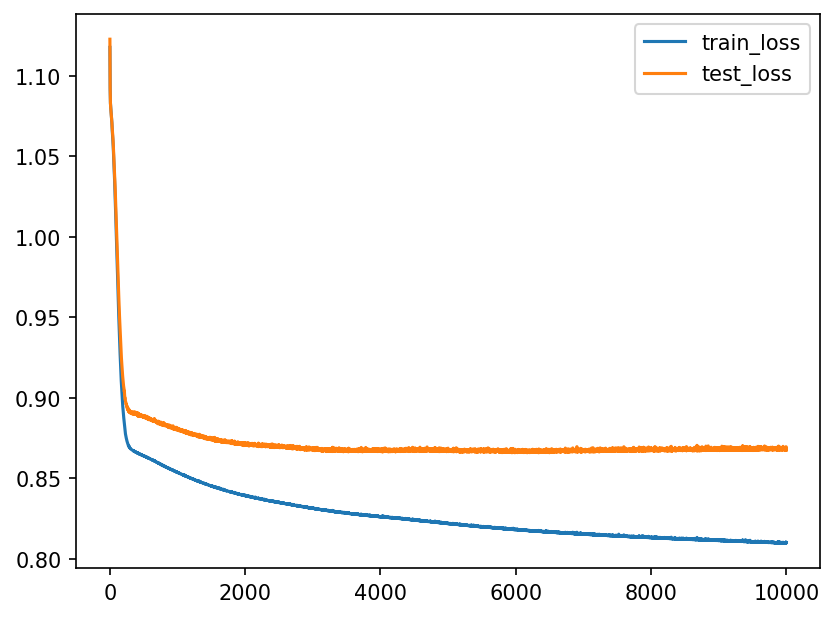

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.plot(range(epoch), train_loss, label='train_loss')
plt.plot(range(epoch), test_loss, label='test_loss')
plt.legend()

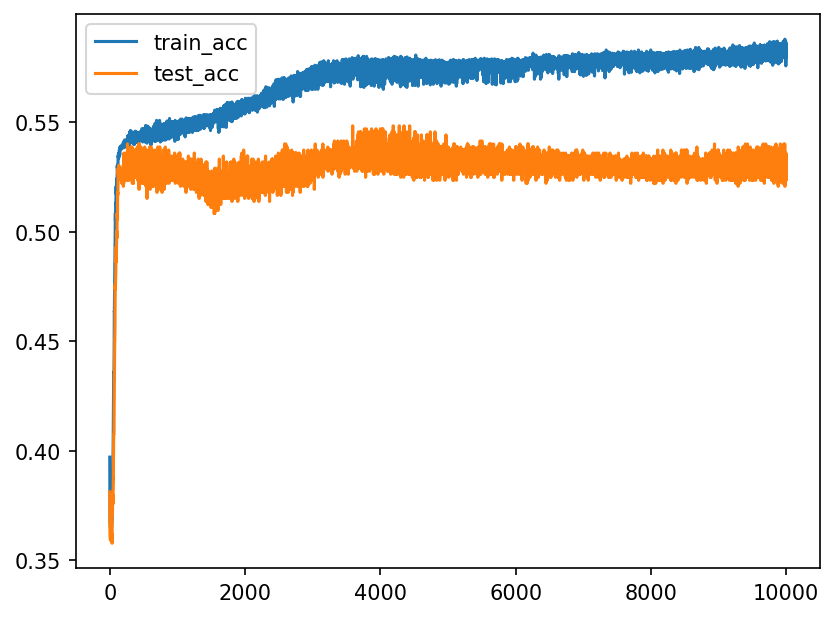

In [ ]:
plt.figure(dpi=150)
plt.plot(range(epoch), train_acc, label='train_acc')
plt.plot(range(epoch), test_acc, label='test_acc')
plt.legend()